In [1]:
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm
from sklearn import metrics
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
%matplotlib inline

In [ ]:
### Wstęp
Poniższy projekt ma na celu dokonania predykcji problematyczności klientów funduszy pożyczkowych, 
dane zaczeprniętesą z "https://www.lendingclub.com/" i opiewają na mniej więcej 140 zmiennych dotyczących około 
300,000 anonimowych klientów.
Specyfika danych pozwala na nie tyle predykcje spłacenia lub nie, a próbę wymierzenia średniego 
opoźnienia w płatnościach już obecnych klientów które wymagają odpowiednio zakumulowanej wcześniej rezerwy.
W poniższej analizie dzielę klientów na 2 grupy, 
pożądanych (spóźnienia w płatnościach do max 30 dni) i nieporządanych (spóźnienia dłuższe + niespłacenia).
W ten sposób sklasyfikowana zmienna binarna jest oceniana metryką uśrednionej precyzji, jest to jedyna
tak efektywna metryka niewymagająca ekspertyzy co do punktu odcięcia i działająca na tak niezbalansowanym zbiorze.

In [ ]:
# Ładowanie danych

In [2]:
d1 = pd.read_csv("data/LoanStats2017_q1.csv", header = 1)
d2 = pd.read_csv("data/LoanStats2017_q2.csv", header = 1)
d3 = pd.read_csv("data/LoanStats2017_q3.csv", header = 1)

/home/krzysztof/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,118,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/krzysztof/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/krzysztof/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df = pd.concat([d1[:-4], d2[:-4], d3[:-4]], axis=0, ignore_index=True)

In [ ]:
# EAD i preprocessing

In [4]:
df.dropna(subset = ['loan_status'], inplace = True)

In [5]:
df = df.drop(['funded_amnt', 'id', 'member_id', 'url', 'desc', 'title', 'zip_code', 'out_prncp_inv', 'total_pymnt_inv', 'emp_title', 'sub_grade', 'next_pymnt_d', 'hardship_type', 'funded_amnt_inv', 'last_pymnt_amnt', 'annual_inc_joint', 'payment_plan_start_date', 'deferral_term', 'hardship_length', 'hardship_end_date', 'settlement_date'], axis=1)

In [6]:
df['term'] = df['term'].apply(lambda x: 1080 if x==' 36 months' else 1800)

In [7]:
df['int_rate'] = df['int_rate'].apply(lambda x: float(x.strip('%'))/100)

In [8]:
df['emp_length'] = df['emp_length'].apply(lambda x: 0.5 if x=='< 1 year' else (1 if x=='1 year' else (2 if x=='2 years' else (3 if x=='3 years' else (4 if x=='4 years' else (5 if x=='5 years' else (6 if x=='6 years' else (7 if x=='7 years' else (8 if x=='8 years' else (9 if x=='9 years' else (10 if x=='10+ years' else 0)))))))))))

In [9]:
df['loan_status'] = df['loan_status'].apply(lambda x: 0 if (x == 'Fully Paid' or x == 'Current' or x == 'In Grace Period' or x == 'Late (16-30 days)') else 1)

In [10]:
df['pymnt_plan'] = df['pymnt_plan'].apply(lambda x: 0 if x=='n' else 1)

In [11]:
months_dict = {'Jan' : 0, 'Feb' : 1, 'Mar' : 2, 'Apr' : 3, 'May' : 4, 'Jun' : 5, 'Jul' : 6, 'Aug' : 7, 'Sep' : 8, 'Oct' : 9, 'Nov' : 10, 'Dec' : 11}

In [12]:
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda x: (2017-int(x[-4:]))*12-months_dict[x[:3]])

In [13]:
df['revol_util'] = df['revol_util'].apply(lambda x: float(str(x).strip('%'))/100)

In [14]:
df['last_credit_pull_d'].fillna('Dec-2017', inplace=True)

In [15]:
df['last_credit_pull_d'] = df['last_credit_pull_d'].apply(lambda x: (2017-int(str(x)[-4:]))*12+11-months_dict[str(x)[:3]])

In [16]:
df['sec_app_earliest_cr_line'] = df['sec_app_earliest_cr_line'].apply(lambda x: (2017-int(x[-4:]))*12-months_dict[x[:3]] if pd.notnull(x) else 0)

In [17]:
df['mths_since_last_major_derog'].fillna(200, inplace = True)

In [18]:
df['mths_since_recent_bc_dlq'].fillna(200, inplace = True)

In [19]:
df['mths_since_recent_revol_delinq'].fillna(200, inplace = True)

In [20]:
to_std = ['installment', 'loan_amnt', 'term', 'mths_since_last_major_derog', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'annual_inc', 'dti', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'tot_coll_amt', 'delinq_amnt', 'num_tl_120dpd_2m', 'tax_liens', 'sec_app_earliest_cr_line', 'last_credit_pull_d', 'earliest_cr_line']

In [21]:
df[to_std] = df[to_std].apply(lambda x: ((x-x.mean())/x.std()))

In [22]:
import sys
from sklearn import preprocessing

In [23]:
catFeatures = ['term', 'grade', 'home_ownership', 'verification_status', 'issue_d', 'purpose', 'addr_state', 'initial_list_status', 'last_pymnt_d', 'application_type', 'verification_status_joint', 'num_tl_30dpd', 'hardship_reason', 'hardship_status', 'hardship_start_date', 'hardship_loan_status', 'disbursement_method', 'debt_settlement_flag_date', 'settlement_status', 'hardship_flag', 'debt_settlement_flag']

In [24]:
df_o = df.copy()
df_o = df_o.fillna(0)
mapy = {}
target = 'loan_status'
for feature in catFeatures:
    le = preprocessing.LabelEncoder()
    df_o[feature] = le.fit_transform(df[feature].apply(str))
    mapy[feature] = le
features = df.columns.tolist()
features.remove(target)

In [95]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

In [208]:
# wydzielanie podpróbki treningowej
XbRF = df_o.sample(frac=0.1)

In [1]:
### 
Wydzielam podpróbkę treningową, frakcja jest zależna tylko od mocy obliczeniowej komputera, przy niskich 
frakcjach (>0.05) uważać na klątwę losowości i wymiarowości (ryzyko silnego przetrenowywania).
Następnie klasycznie dla takich problemów uruchamiam algorytm lasów losowych, w przeciwieństwie do sieci 
neuronowych nie wymaga dodatkowego preprocessingu danych nieustrukturyzowanych.

SyntaxError: invalid syntax (<ipython-input-1-675e974fb235>, line 2)

In [204]:
# Wraper do lasów losowych
def CVTestRFClass(nFolds = 5, randomState=2020, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    for train, test in kf.split(XbRF.index.values):
        clf = RandomForestClassifier(*args, **kwargs, random_state=randomState, n_jobs=-1)
        clf.fit(XbRF.iloc[train][features], XbRF.iloc[train][target])
        predsTrain = clf.predict_proba(XbRF.iloc[train][features])[:,1]
        preds = clf.predict_proba(XbRF.iloc[test][features])[:,1]
        

        predictions.append(preds.tolist().copy())
        

        indices.append(XbRF.iloc[test].index.tolist().copy())
      
        trainScore = average_precision_score(XbRF[target].iloc[train], predsTrain)
        testScore = average_precision_score(XbRF[target].iloc[test], preds)

        trainResults.append(trainScore)
        testResults.append(testScore)
        
    return trainResults, testResults, predictions, indices

In [28]:
df['loan_status'].describe()

count    324910.000000
mean          0.024868
std           0.155724
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: loan_status, dtype: float64

In [29]:
# Wyniki na lasach losowych
trainResults, testResults, predictions, indices = CVTestRFClass()
print(testResults)
print(np.mean(testResults))

[0.9330954160103739, 0.9233065345660664, 0.936957147711446, 0.9399426993340584, 0.9350467785801584]
0.9336697152404205


In [ ]:
###
Wyniki precyzji na poziomie 0.93 są dość obiecujące, niemniej zbiór zmiennych z pewnością wymaga regularyzacji.
Kolejnym krokiem jest wykorzytanie XGB, o ile faktycznie XGB jest stworzony do obrony przed niedotrenowaniem a 
zbiór jest objęty ryzykiem silnego przetrenowania to przy odpowiednim monitorowaniu wyników na zbiorach treningowych 
i testowych można się pokusić o silną regularyzację.

In [29]:
from operator import itemgetter
import time
import xgboost as xgb

In [205]:
# Wraper do XGB
def run_xgb(train, validate, features, target, # argumenty obowiązkowe
            eta=0.03, max_depth=7, subsample = 0.7, colsample_bytree = 0.7, # hiperparametry
            colsample_bylevel=1,lambdaX = 1, alpha=0, gamma=0, min_child_weight=0, # hiperparametry
            rate_drop = 0.2, skip_drop=0.5, # hiperparametry
            num_boost_round = 1000, early_stopping_rounds = 50, # hiperparametry
            debug=True, eval_metric= ["auc"], objective = "binary:logistic", # konfiguracja
            seed=2017, booster = "gbtree", tree_method="exact", grow_policy="depthwise"): # konfiguracja
   
   
    start_time = time.time()
    paramList= ['eta', 'max_depth',
         'subsample', 'colsample_bytree', 'colsample_bylevel',
         'lambdaX', 'alpha', 'gamma', 'min_child_weight',
         'num_boost_round', 'early_stopping_rounds',
         'rate_drop', 'skip_drop',
         'eval_metric', 'objective', 
          'seed', 'booster', 'tree_method', 'grow_policy']
    
    # Stworzenie słownika do przekazania do XGB
    params = dict()
    for param in paramList:
        params[param]=eval(param)
    if(debug):
        for param in paramList:
            print(param, eval(param), end=", ")
        print('\nLength train:', len(train.index))
        print('Length valid:', len(validate.index))

    # Automatyczne przekazanie liczby klas dla wielu poziomów klasyfikacji
    if (params["objective"]=="multi:softmax" or params["objective"]=="multi:softprob"):
        params["num_class"]=train[target].nunique()
    params["silent"]=1
    
    # XGB wymaga w słowniku parametrów słowa kluczowego lambda, poniżej workaround
    params["lambda"]=lambdaX
    
    # Przekształcenie zbiorów do struktury DMatrix
    # Struktura danych DMatrix pozwala na efektywne tworzenie drzew
    dtrain = xgb.DMatrix(train[features].values, train[target].values, feature_names=train[features].columns.values)
    dvalid = xgb.DMatrix(validate[features].values, validate[target].values, feature_names=validate[features].columns.values)

    # Stworzenie listy zbiorów do ealuacji
    evals = [(dtrain, 'train'), (dvalid, 'valid')]
    
    # Stworzenie zmiennej słownikowej do przekazania
    train_history = dict()

    # Uruchomienie algorytmu trenującego
    gbm = xgb.train(params, dtrain, 
                    num_boost_round, early_stopping_rounds=early_stopping_rounds,
                    evals=evals, evals_result=train_history, verbose_eval=debug)
    
    # Obliczenai statystyk i dodatkowych wartości
    score = gbm.best_score

    # Przekształcenie historii trenowania do Pandas Data Frame
    trainHistory = dict()
    for key in train_history.keys():
        for metric in train_history[key].keys():
            trainHistory[key+metric.upper()]=train_history[key][metric]
    train_history = pd.DataFrame(trainHistory)

    # Zapis przewidywanych wartości dla zbioru walidacyjnego dla najlepszej (z punktu widzenia walidacji) iteracji
    trainPred = gbm.predict(dtrain, ntree_limit=gbm.best_iteration)
    testPred = gbm.predict(dvalid, ntree_limit=gbm.best_iteration)

    # Przygotowanie posortowanej listy dla wazności zmiennych, zamaist słownika
    imp = gbm.get_fscore()
    imp = sorted(imp.items(), key=itemgetter(1), reverse=True)

    impFig=None
    if(debug):
        print('Czas trenowania: {} minut'.format(round((time.time() - start_time)/60, 2)))
        # Skorzystanie z wbudowanej funkcji wizualizującej waznośc zmiennych
        impFig, ax = plt.subplots()
        xgb.plot_importance(gbm, ax=ax)
    return score, trainPred, testPred, train_history, impFig, imp

In [206]:
#XGB
def XGBTest(nFolds = 5, randomState=2020, features=features, debug = False, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    hists = []
    fold = 1
    for train, test in kf.split(XbRF.index.values):
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(XbRF.iloc[train], XbRF.iloc[test],
                                                                         features, target, debug=debug, *args, **kwargs)
        predictions.append(testPred.tolist().copy())
        

        indices.append(XbRF.iloc[test].index.tolist().copy())
        
        
        trainScore = average_precision_score(XbRF[target].iloc[train], trainPred)
        testScore = average_precision_score(XbRF[target].iloc[test], testPred)

        trainResults.append(trainScore)
        testResults.append(testScore)
        
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
        
    return trainResults, testResults, predictions, indices, pd.concat(hists, axis=1)

In [207]:
# Wyniki na XGB (po random search)
trainResults, testResults, predictions, indices, hists = XGBTest(
    max_depth=15, lambdaX=4, subsample=0.7, colsample_bytree=0.7, gamma=0.1, debug=False)
testResults

[0.9722412006664634,
 0.96903534450884,
 0.9736671234928572,
 0.9678963410535179,
 0.9724186626945139]

In [ ]:
###
Jak warto zaznaczyć są to wyniki na foldach testowych, XGB na foldach treningowych osiąga wyniki bliskie 1. 
Hiperparematry zostały wylosowane random searchem zdefiniowanym poniżej. (Uwaga operacja czasochłonna)

In [77]:
# Random search do XGB, na podpróbce 0.1 trzykrotnie

In [78]:
dict_of_parameters = {'max_depth' : [4, 16], 'lambdaX' : [1, 8], 'subsample' : [0.2, 1], 'colsample_bytree' : [0.2, 1], 'gamma' : [0.01, 0.3]}

In [79]:
best_score = 0
best_parameters = {'max_depth' : 8, 'lambdaX' : 4, 'subsample' : 0.7, 'colsample_bytree' : 0.7, 'gamma' : 0.1}

In [209]:
for i in dict_of_parameters:
    for r in range(15):
        max_depth = best_parameters['max_depth']
        lambdaX = best_parameters['lambdaX']
        subsample = best_parameters['subsample']
        colsample_bytree = best_parameters['colsample_bytree']
        gamma = best_parameters['gamma']
        
        rand = (dict_of_parameters[i][1] - dict_of_parameters[i][0]) * np.random.random_sample() + dict_of_parameters[i][0]
        if i in ['max_depth', 'lambdaX']:
            rand = int(rand)
        exec("%s = %d" % (i,rand))
        
        trainResults, testResults, predictions, indices, hists = XGBTest(
        max_depth=max_depth, lambdaX=lambdaX, subsample=subsample, colsample_bytree=colsample_bytree, gamma=gamma, debug=False)
    
        Vali = np.mean(testResults)
        
        if Vali > best_score:
            best_parameters[i] = rand
            best_score = Vali
        print(r, i)
print(best_parameters)

0 max_depth
1 max_depth


KeyboardInterrupt: 

In [ ]:
###
Sieci neuronowe, o ile jest to w istocie wielokrotnie złożona regresja logistyczna sposób działania 
mają kompletnie inny niż lasy losowe, dlatego też ensebling tych dwóch algorytmów pozostaje bardzo efektywnym 
narzędziem mimo nieklasyczności zbioru.

In [36]:
from __future__ import print_function

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing.text import Tokenizer
from keras.layers.advanced_activations import PReLU


from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import gc

Using TensorFlow backend.


In [37]:
#przygotowanie zmiennych kategorycznych przez onehot encoder

In [ ]:
###
Właściwie cały dodatkowy preprocessing, zmienne standaryzuje pod wylosowany fold treningowy, kategoryczne są 
przerabiane one-hot encoderem.

In [195]:
df_oNN = df.sample(frac= 1).copy()
dummLev = pd.get_dummies(df_oNN[catFeatures], drop_first=True)
tr = df_oNN.drop(columns = catFeatures)
df_oNN = pd.concat([tr, dummLev], axis=1)
feat = df_oNN.columns.tolist()
feat.remove(target)

In [ ]:
# Standaryzacja zmiennych pod wylosowaną podpróbkę

In [196]:
std = df_oNN.columns[df_oNN.mean(axis=0) > 2].tolist()

In [197]:
df_oNN[std] = df_oNN[std].apply(lambda x: ((x-x.mean())/x.std()))

In [ ]:
# Model NN

In [198]:
model = Sequential()
model.add(Dense(180, input_dim=len(df_oNN.columns.tolist())-1, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [199]:
opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
# Musiały wkraść się infy i nany więc zamieniam na 0 (w NN jak i w regresjach logistycznych nie powinno być problemu)

In [200]:
df_oNN[feat] = df_oNN[feat].replace([np.inf, -np.inf, np.nan], 0)

In [ ]:
# Wrapper do NN

In [201]:
def NN():
    kf = KFold(n_splits=7, shuffle=True, random_state=2020)
    scores = []
    indices = []
    for train, test in kf.split(df_oNN.index.values):
        model.fit(df_oNN.iloc[train][feat], df_oNN.iloc[train][target], epochs=20, batch_size=32)
        y_pred = model.predict(df_oNN.iloc[test][feat])
        Y_real = df_oNN.iloc[test][target]
        Score = average_precision_score(Y_real, y_pred)
        scores.append(Score)
        indices.append(df_oNN.iloc[test].index.tolist().copy())

    return(scores, y_pred)
        

In [202]:
# Wyniki na sieciach
scores, y_predNN = NN()
np.mean(scores)

Epoch 1/20
278494/278494 [==============================] - 22s 80us/step - loss: 0.1451 - accuracy: 0.9560
Epoch 2/20
278494/278494 [==============================] - 21s 77us/step - loss: 0.0508 - accuracy: 0.9844
Epoch 3/20
278494/278494 [==============================] - 21s 74us/step - loss: 0.0351 - accuracy: 0.9889
Epoch 4/20
278494/278494 [==============================] - 18s 65us/step - loss: 0.0269 - accuracy: 0.9917
Epoch 5/20
278494/278494 [==============================] - 19s 68us/step - loss: 0.0221 - accuracy: 0.9934
Epoch 6/20
278494/278494 [==============================] - 19s 69us/step - loss: 0.0194 - accuracy: 0.9943
Epoch 7/20
278494/278494 [==============================] - 19s 67us/step - loss: 0.0178 - accuracy: 0.9949
Epoch 8/20
278494/278494 [==============================] - 18s 66us/step - loss: 0.0167 - accuracy: 0.9952
Epoch 9/20
278494/278494 [==============================] - 18s 66us/step - loss: 0.0158 - accuracy: 0.9955
Epoch 10/20
278494/278494 [=

0.9846929008089065

In [ ]:
###
Wynik na sieciach jest bardzo przyzwoity jak na nieprzyjemny teren pod analizę złożoną, wszelkie hiperparametry, 
optimizer, predkosc nauki, dropout były ustalane poza tym dokumentem, opierając się na równaniach stochastycznych i
własnemu doświadczneiu do tego typu problemów.

In [ ]:
#ensembling NN i XGB

In [127]:
target

'loan_status'

In [128]:
def XGB_ens(train, test, df_oNN):
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(df_oNN.iloc[train], df_oNN.iloc[test],
                                                                         feat, target)
    return testPred

In [129]:
def NN_ens(train, test, df_oNN):
    model.fit(df_oNN.iloc[train][feat], df_oNN.iloc[train][target], epochs=50, batch_size=32)
    y_pred = model.predict(df_oNN.iloc[test][feat])
    return y_pred

In [172]:
from sklearn.linear_model import LogisticRegression
def ensemble():
    kf = KFold(n_splits=7, shuffle=True, random_state=2020)
    scores = []
    for train, test in kf.split(df_oNN.index.values):
        pom = NN_ens(train, test, df_oNN).flatten()
        d = {'XGB': XGB_ens(train, test, df_oNN), "NN" : pom}
        print(d['NN'].shape)
        ens_df = pd.DataFrame(data=d)
        
        clf = LogisticRegression(random_state=0).fit(ens_df, df_oNN.iloc[test][target])
        y_pred = clf.predict_proba(ens_df)
        S = average_precision_score(df_oNN.iloc[test][target], y_pred[:,1])
        scores.append(S)
    return scores

Epoch 1/50
2784/2784 [==============================] - 0s 90us/step - loss: 17.9029 - accuracy: 0.9526
Epoch 2/50
2784/2784 [==============================] - 0s 91us/step - loss: 17.9168 - accuracy: 0.9526
Epoch 3/50
2784/2784 [==============================] - 0s 89us/step - loss: 17.8876 - accuracy: 0.9540
Epoch 4/50
2784/2784 [==============================] - 0s 78us/step - loss: 17.8962 - accuracy: 0.9526
Epoch 5/50
2784/2784 [==============================] - 0s 82us/step - loss: 17.8848 - accuracy: 0.9522
Epoch 6/50
2784/2784 [==============================] - 0s 77us/step - loss: 17.8682 - accuracy: 0.9526
Epoch 7/50
2784/2784 [==============================] - 0s 74us/step - loss: 17.8551 - accuracy: 0.9529
Epoch 8/50
2784/2784 [==============================] - 0s 74us/step - loss: 17.8443 - accuracy: 0.9529
Epoch 9/50
2784/2784 [==============================] - 0s 80us/step - loss: 17.8425 - accuracy: 0.9526
Epoch 10/50
2784/2784 [==============================] - 0s 84us

[58]	train-auc:0.999981	valid-auc:0.984593
[59]	train-auc:0.999981	valid-auc:0.984444
[60]	train-auc:0.999981	valid-auc:0.984444
[61]	train-auc:0.999981	valid-auc:0.984593
[62]	train-auc:0.999981	valid-auc:0.985185
[63]	train-auc:0.999981	valid-auc:0.985185
[64]	train-auc:0.999981	valid-auc:0.985185
[65]	train-auc:0.999981	valid-auc:0.986074
[66]	train-auc:0.999981	valid-auc:0.986074
[67]	train-auc:0.999981	valid-auc:0.985926
[68]	train-auc:0.999981	valid-auc:0.985926
[69]	train-auc:0.999981	valid-auc:0.986074
[70]	train-auc:0.999986	valid-auc:0.985926
[71]	train-auc:0.999986	valid-auc:0.985778
[72]	train-auc:0.999986	valid-auc:0.98563
[73]	train-auc:0.999986	valid-auc:0.98563
[74]	train-auc:0.999995	valid-auc:0.98563
[75]	train-auc:0.999995	valid-auc:0.985926
[76]	train-auc:1	valid-auc:0.985482
[77]	train-auc:1	valid-auc:0.98563
[78]	train-auc:1	valid-auc:0.98563
[79]	train-auc:1	valid-auc:0.98637
[80]	train-auc:1	valid-auc:0.986519
[81]	train-auc:1	valid-auc:0.987407
[82]	train-auc:1

2785/2785 [==============================] - 0s 73us/step - loss: 20.1127 - accuracy: 0.9487
Epoch 2/50
2785/2785 [==============================] - 0s 70us/step - loss: 20.0975 - accuracy: 0.9476
Epoch 3/50
2785/2785 [==============================] - 0s 69us/step - loss: 20.0807 - accuracy: 0.9465
Epoch 4/50
2785/2785 [==============================] - 0s 67us/step - loss: 20.0791 - accuracy: 0.9490
Epoch 5/50
2785/2785 [==============================] - 0s 72us/step - loss: 20.0464 - accuracy: 0.9479
Epoch 6/50
2785/2785 [==============================] - 0s 69us/step - loss: 20.0329 - accuracy: 0.9479
Epoch 7/50
2785/2785 [==============================] - 0s 70us/step - loss: 20.0128 - accuracy: 0.9469
Epoch 8/50
2785/2785 [==============================] - 0s 69us/step - loss: 20.0096 - accuracy: 0.9472
Epoch 9/50
2785/2785 [==============================] - 0s 68us/step - loss: 19.9807 - accuracy: 0.9476
Epoch 10/50
2785/2785 [==============================] - 0s 68us/step - los

[58]	train-auc:0.999896	valid-auc:0.984347
[59]	train-auc:0.999896	valid-auc:0.984347
[60]	train-auc:0.999901	valid-auc:0.984347
[61]	train-auc:0.99991	valid-auc:0.984347
[62]	train-auc:0.999905	valid-auc:0.984347
[63]	train-auc:0.999919	valid-auc:0.984547
[64]	train-auc:0.999941	valid-auc:0.984547
[65]	train-auc:0.999955	valid-auc:0.984347
[66]	train-auc:0.999955	valid-auc:0.984547
[67]	train-auc:0.999955	valid-auc:0.984347
[68]	train-auc:0.999955	valid-auc:0.984547
[69]	train-auc:0.999955	valid-auc:0.984347
[70]	train-auc:0.999955	valid-auc:0.984146
[71]	train-auc:0.999955	valid-auc:0.983745
[72]	train-auc:0.999955	valid-auc:0.986153
[73]	train-auc:0.999955	valid-auc:0.986354
[74]	train-auc:0.999955	valid-auc:0.986153
Stopping. Best iteration:
[24]	train-auc:0.99302	valid-auc:0.987257

Czas trenowania: 0.07 minut
(464,)
70675     0
188170    0
66403     0
268674    0
10129     0
         ..
268540    0
253395    0
93077     0
234398    0
81673     0
Name: loan_status, Length: 464, dt

[111]	train-auc:1	valid-auc:1
[112]	train-auc:1	valid-auc:1
[113]	train-auc:1	valid-auc:1
[114]	train-auc:1	valid-auc:1
[115]	train-auc:1	valid-auc:1
[116]	train-auc:1	valid-auc:1
[117]	train-auc:1	valid-auc:1
[118]	train-auc:1	valid-auc:1
[119]	train-auc:1	valid-auc:1
[120]	train-auc:1	valid-auc:1
[121]	train-auc:1	valid-auc:1
[122]	train-auc:1	valid-auc:1
[123]	train-auc:1	valid-auc:1
[124]	train-auc:1	valid-auc:1
[125]	train-auc:1	valid-auc:1
[126]	train-auc:1	valid-auc:1
[127]	train-auc:1	valid-auc:1
[128]	train-auc:1	valid-auc:1
[129]	train-auc:1	valid-auc:1
[130]	train-auc:1	valid-auc:1
[131]	train-auc:1	valid-auc:1
[132]	train-auc:1	valid-auc:1
[133]	train-auc:1	valid-auc:1
[134]	train-auc:1	valid-auc:1
[135]	train-auc:1	valid-auc:1
[136]	train-auc:1	valid-auc:1
Stopping. Best iteration:
[86]	train-auc:0.999991	valid-auc:1

Czas trenowania: 0.13 minut
(464,)
242268    0
235479    0
110404    0
295719    0
308730    0
         ..
48497     0
91491     0
29654     0
171374    0
29

[102]	train-auc:1	valid-auc:0.996418
[103]	train-auc:1	valid-auc:0.996759
[104]	train-auc:1	valid-auc:0.996589
[105]	train-auc:1	valid-auc:0.996759
[106]	train-auc:1	valid-auc:0.9971
[107]	train-auc:1	valid-auc:0.9971
[108]	train-auc:1	valid-auc:0.99693
[109]	train-auc:1	valid-auc:0.99693
[110]	train-auc:1	valid-auc:0.9971
[111]	train-auc:1	valid-auc:0.996759
[112]	train-auc:1	valid-auc:0.996759
[113]	train-auc:1	valid-auc:0.996589
[114]	train-auc:1	valid-auc:0.996589
[115]	train-auc:1	valid-auc:0.99693
[116]	train-auc:1	valid-auc:0.99693
[117]	train-auc:1	valid-auc:0.996759
[118]	train-auc:1	valid-auc:0.996589
[119]	train-auc:1	valid-auc:0.99693
[120]	train-auc:1	valid-auc:0.996759
[121]	train-auc:1	valid-auc:0.99693
[122]	train-auc:1	valid-auc:0.99693
[123]	train-auc:1	valid-auc:0.99693
[124]	train-auc:1	valid-auc:0.997271
[125]	train-auc:1	valid-auc:0.9971
[126]	train-auc:1	valid-auc:0.9971
[127]	train-auc:1	valid-auc:0.99693
[128]	train-auc:1	valid-auc:0.99693
[129]	train-auc:1	val

2785/2785 [==============================] - 0s 140us/step - loss: 16.4394 - accuracy: 0.9537
Epoch 2/50
2785/2785 [==============================] - 0s 90us/step - loss: 16.4152 - accuracy: 0.9537
Epoch 3/50
2785/2785 [==============================] - 0s 75us/step - loss: 16.4087 - accuracy: 0.9508
Epoch 4/50
2785/2785 [==============================] - 0s 108us/step - loss: 16.3956 - accuracy: 0.9526
Epoch 5/50
2785/2785 [==============================] - 0s 106us/step - loss: 16.3891 - accuracy: 0.9544
Epoch 6/50
2785/2785 [==============================] - 0s 71us/step - loss: 16.3825 - accuracy: 0.9526
Epoch 7/50
2785/2785 [==============================] - 0s 73us/step - loss: 16.3675 - accuracy: 0.9555
Epoch 8/50
2785/2785 [==============================] - 0s 78us/step - loss: 16.3651 - accuracy: 0.9512
Epoch 9/50
2785/2785 [==============================] - 0s 77us/step - loss: 16.3591 - accuracy: 0.9548
Epoch 10/50
2785/2785 [==============================] - 0s 73us/step - 

[58]	train-auc:0.99989	valid-auc:0.958287
[59]	train-auc:0.999899	valid-auc:0.958008
[60]	train-auc:0.999899	valid-auc:0.958287
[61]	train-auc:0.999899	valid-auc:0.958566
[62]	train-auc:0.999914	valid-auc:0.958566
[63]	train-auc:0.999918	valid-auc:0.959124
[64]	train-auc:0.999914	valid-auc:0.958984
[65]	train-auc:0.999914	valid-auc:0.958845
[66]	train-auc:0.999928	valid-auc:0.959124
[67]	train-auc:0.999928	valid-auc:0.959403
[68]	train-auc:0.999928	valid-auc:0.959263
Stopping. Best iteration:
[18]	train-auc:0.992377	valid-auc:0.961775

Czas trenowania: 0.05 minut
(464,)
68820     0
57731     0
304358    0
16016     0
141751    0
         ..
11126     0
288934    0
251400    0
124085    0
152569    0
Name: loan_status, Length: 464, dtype: int64 [0.03109072 0.03109072 0.03109072 0.03109072 0.03128093 0.03109072
 0.03109072 0.03109072 0.03109072 0.03109072 0.03109072 0.03109072
 0.03109072 0.03109072 0.03109072 0.03109072 0.03109072 0.03109072
 0.03109072 0.03109072 0.03378751 0.03109072 

[112]	train-auc:1	valid-auc:0.999197
[113]	train-auc:1	valid-auc:0.999197
[114]	train-auc:1	valid-auc:0.999197
[115]	train-auc:1	valid-auc:0.999197
[116]	train-auc:1	valid-auc:0.999197
[117]	train-auc:1	valid-auc:0.999197
[118]	train-auc:1	valid-auc:0.999197
[119]	train-auc:1	valid-auc:0.999197
[120]	train-auc:1	valid-auc:0.999398
[121]	train-auc:1	valid-auc:0.999398
[122]	train-auc:1	valid-auc:0.999398
[123]	train-auc:1	valid-auc:0.999398
[124]	train-auc:1	valid-auc:0.999398
[125]	train-auc:1	valid-auc:0.999398
[126]	train-auc:1	valid-auc:0.999398
[127]	train-auc:1	valid-auc:0.999599
[128]	train-auc:1	valid-auc:0.999599
[129]	train-auc:1	valid-auc:0.999599
[130]	train-auc:1	valid-auc:0.999599
[131]	train-auc:1	valid-auc:0.999599
[132]	train-auc:1	valid-auc:0.999599
[133]	train-auc:1	valid-auc:0.999599
[134]	train-auc:1	valid-auc:0.999599
[135]	train-auc:1	valid-auc:0.999599
[136]	train-auc:1	valid-auc:0.999599
[137]	train-auc:1	valid-auc:0.999599
[138]	train-auc:1	valid-auc:0.999599
[

2785/2785 [==============================] - 0s 70us/step - loss: 17.4551 - accuracy: 0.9515
Epoch 2/50
2785/2785 [==============================] - 0s 72us/step - loss: 17.4359 - accuracy: 0.9551
Epoch 3/50
2785/2785 [==============================] - 0s 71us/step - loss: 17.4110 - accuracy: 0.9540
Epoch 4/50
2785/2785 [==============================] - 0s 69us/step - loss: 17.4009 - accuracy: 0.9537
Epoch 5/50
2785/2785 [==============================] - 0s 69us/step - loss: 17.4042 - accuracy: 0.9533
Epoch 6/50
2785/2785 [==============================] - 0s 68us/step - loss: 17.4159 - accuracy: 0.9544
Epoch 7/50
2785/2785 [==============================] - 0s 71us/step - loss: 17.3802 - accuracy: 0.9537
Epoch 8/50
2785/2785 [==============================] - 0s 75us/step - loss: 17.3626 - accuracy: 0.9537
Epoch 9/50
2785/2785 [==============================] - 0s 82us/step - loss: 17.3607 - accuracy: 0.9544
Epoch 10/50
2785/2785 [==============================] - 0s 72us/step - los

[58]	train-auc:0.999888	valid-auc:0.998413
[59]	train-auc:0.999906	valid-auc:0.998413
[60]	train-auc:0.999911	valid-auc:0.998413
[61]	train-auc:0.999916	valid-auc:0.99873
[62]	train-auc:0.99993	valid-auc:0.99873
[63]	train-auc:0.999939	valid-auc:0.999048
[64]	train-auc:0.999944	valid-auc:0.999048
[65]	train-auc:0.999958	valid-auc:0.999048
[66]	train-auc:0.999953	valid-auc:0.999048
[67]	train-auc:0.999977	valid-auc:0.999048
[68]	train-auc:0.999972	valid-auc:0.999048
[69]	train-auc:0.999977	valid-auc:0.999048
[70]	train-auc:0.999981	valid-auc:0.999048
[71]	train-auc:0.999981	valid-auc:0.999206
[72]	train-auc:0.999991	valid-auc:0.999206
[73]	train-auc:0.999991	valid-auc:0.999206
[74]	train-auc:0.999991	valid-auc:0.999365
[75]	train-auc:0.999995	valid-auc:0.999365
[76]	train-auc:0.999995	valid-auc:0.999365
[77]	train-auc:0.999995	valid-auc:0.999365
[78]	train-auc:0.999995	valid-auc:0.999365
[79]	train-auc:0.999995	valid-auc:0.999365
[80]	train-auc:0.999995	valid-auc:0.999365
[81]	train-auc

0.8672427585732085

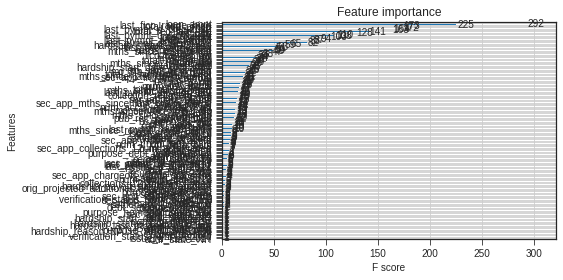

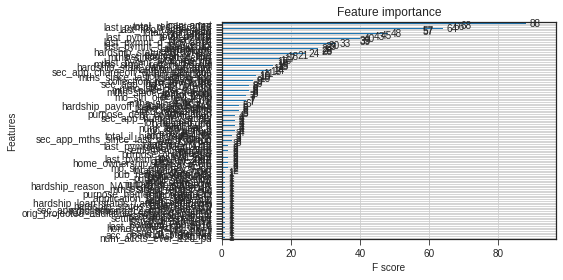

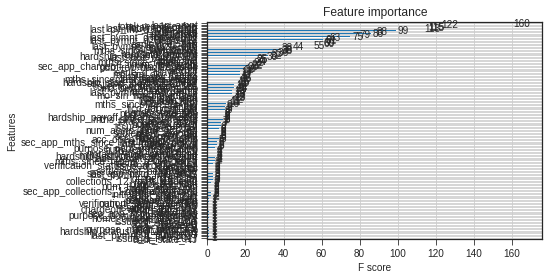

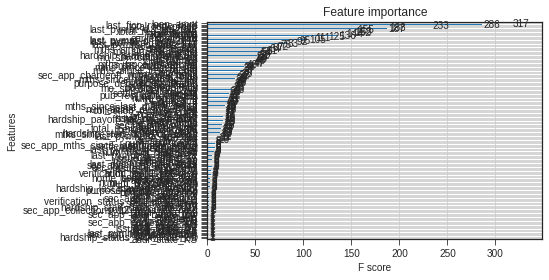

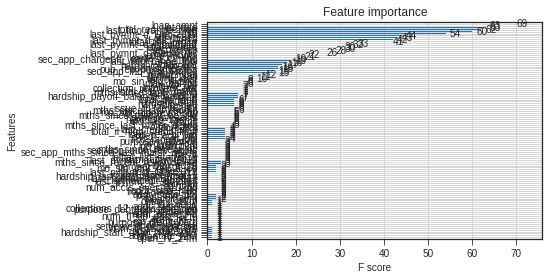

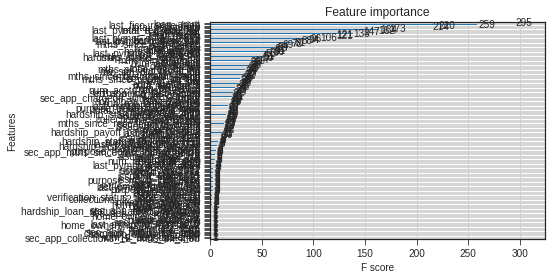

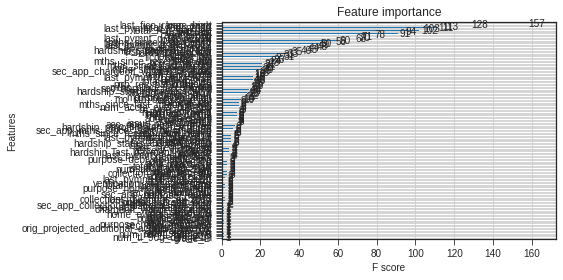

In [173]:
#Wyniki na wcześnmiejszej podpróbce, NN na wycinkach zachowuje sie dość losowo ale wciąż poprawa wobec samego XGB.
a = ensemble()
np.mean(a)